# 画像処理検討ノート

In [1]:
from __future__ import unicode_literals
from __future__ import print_function
import sys
import os
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import json

import chainer
import chainer.functions as F
import chainer.links as L

%matplotlib inline
sns.set_style('whitegrid')

In [120]:
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('__file__')), '..', 'cmd', 'yolo', 'lib'))
from bounding_box import *

In [3]:
sys.version

'2.7.13 |Anaconda 4.3.0 (x86_64)| (default, Dec 20 2016, 23:05:08) \n[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]'

In [4]:
cv2.__version__

'3.1.0'

In [5]:
chainer.__version__

'1.22.0'

## ダミー背景の作成

In [427]:
bg_color_image_path = '/Users/uents/repos/github.com/uents/chainer-playground/dl-course/contest/APC/Single/Single/2/13/color.bmp'
bg_label_image_path = '/Users/uents/repos/github.com/uents/chainer-playground/dl-course/contest/APC/Single/mask_label/single/2/13/label.bmp'

In [428]:
bg_color_image = cv2.imread(bg_color_image_path)
bg_label_image = cv2.imread(bg_label_image_path, 0)

In [440]:
bg_label_image.shape[:2]

(960, 1280)

In [433]:
_, _, stats, centroids = cv2.connectedComponentsWithStats(bg_label_image)
stats, centroids

for stat, centroid in zip(stats, centroids):
    region_x, region_y, region_w, region_h, _ = stat[0], stat[1], stat[2], stat[3], stat[4]
    centor_x, centor_y = int(math.floor(centroid[1])), int(math.floor(centroid[0]))
    if region_w * region_h <= (2 * bg_label_image.shape[1]):
        continue
    if region_w * region_h >= (bg_label_image.shape[0] * bg_label_image.shape[1] * 0.95):
        continue
    break

region_x, region_y, region_w, region_h

(712, 676, 124, 188)

In [445]:
240 * 180

43200

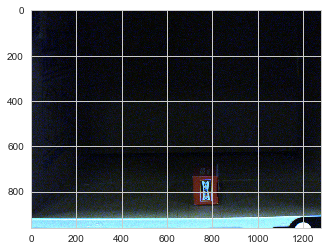

In [434]:
fig, axes = plt.subplots(1,1)
axes.imshow(cv2.cvtColor(bg_color_image, cv2.COLOR_BGR2RGB))

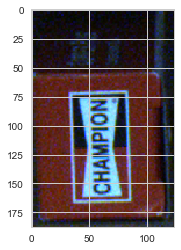

In [436]:
fig, axes = plt.subplots(1,1)
axes.imshow(cv2.cvtColor(bg_color_image[676:676+188,712:712+124], cv2.COLOR_BGR2RGB))

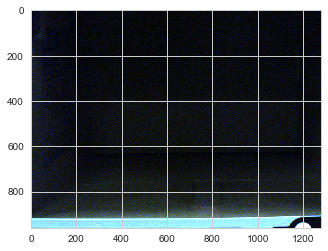

In [439]:
bg_image = color_image1.copy()
bg_image[676:676+188,712:712+124] = bg_color_image[676:676+188,712+124:712+124+124]
fig, axes = plt.subplots(1,1)
axes.imshow(cv2.cvtColor(bg_image, cv2.COLOR_BGR2RGB))

In [453]:
'bg_image%02d.bmp' % 2

u'bg_image02.bmp'

In [324]:
cv2.imwrite('bg.bmp', bg_image)

True

## オブジェクトの抽出

In [331]:
with open(os.path.join('..', 'cache', 'train_catalog.json'), 'r') as fp:
    catalog = json.load(fp)
    
train_dataset = filter(lambda item: item['bounding_boxes'] != [], catalog['dataset'])
len(train_dataset)

729

In [332]:
train_dataset[0]

{u'bounding_boxes': [{u'class': u'2',
   u'height': u'184',
   u'width': u'358',
   u'x': u'352',
   u'y': u'696'}],
 u'classes': [u'2'],
 u'color_image_path': u'/Users/uents/repos/github.com/uents/chainer-playground/dl-course/contest/APC/Single/Single/2/15/color.bmp',
 u'depth_image_path': u'/Users/uents/repos/github.com/uents/chainer-playground/dl-course/contest/APC/Single/Single/2/15/depth.bmp.bmp',
 u'label_image_path': u'/Users/uents/repos/github.com/uents/chainer-playground/dl-course/contest/APC/Single/mask_label/single/2/15/label.bmp',
 u'pattern_id': u'15'}

In [333]:
color_image_path = train_dataset[0]['color_image_path']
label_image_path = train_dataset[0]['label_image_path']
bounding_box = train_dataset[0]['bounding_boxes'][0]

bounding_box

{u'class': u'2',
 u'height': u'184',
 u'width': u'358',
 u'x': u'352',
 u'y': u'696'}

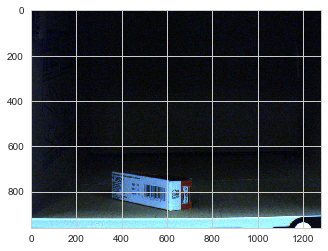

In [349]:
color_image = cv2.imread(color_image_path)
fig, axes = plt.subplots(1,1)
axes.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))

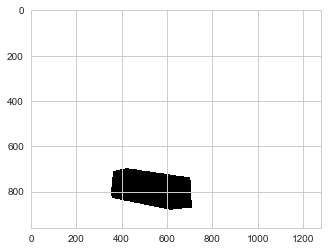

In [353]:
label_image = cv2.imread(label_image_path, 0)
fig, axes = plt.subplots(1,1)
axes.imshow(label_image)

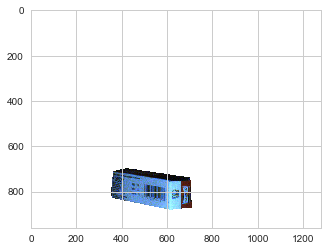

In [363]:
roi_image = cv2.bitwise_and(color_image, color_image, mask=label_image)
roi_image = cv2.cvtColor(roi_image, cv2.COLOR_BGR2BGRA)
roi_image[label_image == 0, 3] = 0

fig, axes = plt.subplots(1,1)
axes.imshow(cv2.cvtColor(roi_image, cv2.COLOR_BGRA2RGBA))

<Box x:352.0 y:696.0 w:358.0 h:184.0 c: 0 o:1.000>


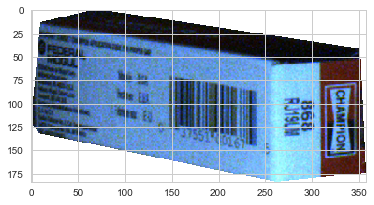

In [364]:
box = Box(
    x=int(bounding_box['x']),
    y=int(bounding_box['y']),
    width=int(bounding_box['width']),
    height=int(bounding_box['height'])
)
print(box)

roi_image = roi_image[box.top:box.bottom,box.left:box.right]
fig, axes = plt.subplots(1,1)
axes.imshow(cv2.cvtColor(roi_image, cv2.COLOR_BGRA2RGBA))

In [149]:
def rotate_image(image, angle):
    return scipy.ndimage.rotate(image, angle, reshape=True)

def scale_image(image, scale):
    h, w = image.shape[:2]
    return cv2.resize(image, (int(w*scale), int(h*scale)))

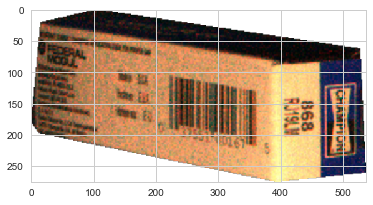

In [365]:
image = scale_image(roi_image, 1.5)
fig, axes = plt.subplots(1,1)
axes.imshow(image)

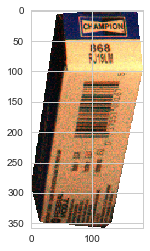

In [397]:
image = rotate_image(roi_image, 90)
fig, axes = plt.subplots(1,1)
axes.imshow(image)

In [413]:
h, w = image.shape[:2]

print(h,w)

358 184


## オブジェクトをダミー背景に重畳

In [392]:
import PIL

In [461]:
new_image = PIL.Image.fromarray(cv2.cvtColor(bg_image, cv2.COLOR_BGR2RGBA))
overlay_image = PIL.Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA))

In [464]:
new_image.paste(overlay_image, box=(480, 960 - h - 100), mask=overlay_image)

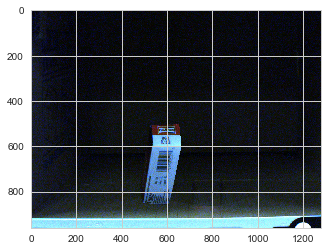

In [465]:
fig, axes = plt.subplots(1,1)
axes.imshow(new_image)

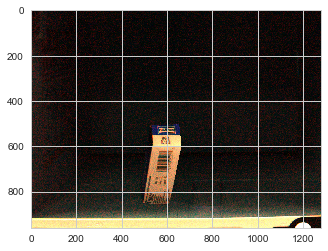

In [481]:
img = cv2.cvtColor(np.asarray(new_image), cv2.COLOR_RGBA2BGR)
fig, axes = plt.subplots(1,1)
axes.imshow(img)

In [486]:
np.random.choice(['a', 'b', 'c', 'd'])

u'a'